In [26]:
import warnings

warnings.filterwarnings("ignore")

import itertools
import os
import random
from scipy.signal import convolve2d
import sys
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
import xarray as xr
from torch.utils.data import Dataset
import math
from tqdm import tqdm

import torch, scipy
import torch.fft

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

from holodec.transforms import LoadTransformations
from holodec.propagation import WavePropagator

# from holodecml.seed import seed_everything
from holodec.datasets import LoadHolograms
from holodec.unet import load_model
from holodec.losses import load_loss

from collections import defaultdict
from argparse import ArgumentParser
from pathlib import Path
from torch.utils.data import Dataset

import xarray as xr
import torch.nn.functional as F
import pandas as pd
import numpy as np
import subprocess
import torch.fft
import logging
import shutil
import random
import psutil
import optuna
import torch
import time
import tqdm
import gc
import os
import sys
import itertools
import yaml
import warnings

from holodecml.metrics import DistributedROC
from hagelslag.evaluation.MetricPlotter import roc_curve, performance_diagram
from functools import partial

In [2]:
#torch.cuda.empty_cache()

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

print(device)

cuda:0


In [4]:
train_dataset_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc"
test_dataset_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_validation.nc"

In [5]:
conf_file_path = "/glade/work/schreck/repos/HOLO/style/holodec-ml/results/manopt/model.yml" #"../results/batch7/model.yml" 

In [6]:
with open(conf_file_path) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [7]:
model = load_model(conf["model"])
model_dict = torch.load("/glade/work/schreck/repos/HOLO/style/holodec-ml/results/manopt/best.pt")["model_state_dict"]
model.load_state_dict(model_dict)
model = model.to(device)

In [8]:
lookahead = 2 #int(conf["data"]["lookahead"])
conf["model"]["in_channels"] = 2 #* (lookahead + 1)

n_bins = int(conf["data"]["n_bins"])
tile_size = int(conf["data"]["tile_size"])
step_size = int(conf["data"]["step_size"])

train_dataset = LoadHolograms(
    "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc",
    shuffle=False,
    device="cpu",
    n_bins=n_bins,
    transform=None,#LoadTransformations(conf["transforms"]["training"]),
    lookahead=lookahead,
    tile_size=tile_size,
    step_size=step_size
)

In [9]:
random_integer = random.randint(0, train_dataset.__len__())
print("Id", random_integer)
x, part_mask, depth_mask, weight_mask = train_dataset.__getitem__(random_integer)

Id 32016


In [10]:
print(x.shape, part_mask.shape)
print("Mask sum", part_mask.sum())

torch.Size([4, 4872, 3248]) torch.Size([4872, 3248])
Mask sum tensor(74., dtype=torch.float64)


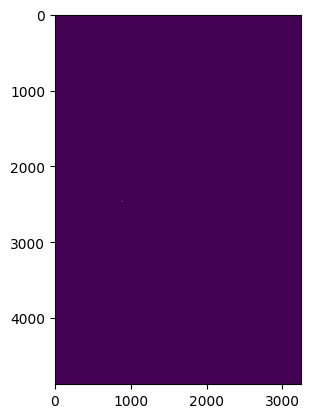

In [11]:
plt.imshow(part_mask)

In [13]:
#y_pred = model(x[0:1].to(device)[:, :4832, :3232].unsqueeze(0) / 255.0)

In [20]:
class InferencePropagator(WavePropagator):

    def __init__(self,
                 data_path,
                 n_bins=n_bins,
                 color_dim=1,
                 tile_size=512,
                 step_size=128,
                 marker_size=10,
                 transform_mode=None,
                 device="cuda",
                 model=None,
                 transforms=None,
                 mode=None,
                 probability_threshold=0.5):

        super(InferencePropagator, self).__init__(
            data_path,
            n_bins=n_bins,
            tile_size=tile_size,
            step_size=step_size,
            marker_size=marker_size,
            transform_mode=transform_mode,
            device=device
        )

        self.model = model
        self.model.eval()
        self.color_dim = color_dim
        self.transforms = transforms
        self.mode = mode
        self.probability_threshold = probability_threshold
        self.create_mapping()

    def create_mapping(self):

        self.idx2slice = {}
        for row_idx in range(self.Nx//self.step_size):

            if row_idx*self.step_size+self.tile_size > self.Nx:
                image_pixel_x = self.Nx-self.tile_size
                row_slice = slice(-self.tile_size, None)
                row_break = True
            else:
                image_pixel_x = row_idx*self.step_size
                row_slice = slice(row_idx*self.step_size,
                                  row_idx*self.step_size+self.tile_size)
                row_break = False

            for col_idx in range(self.Ny//self.step_size):

                if col_idx*self.step_size+self.tile_size > self.Ny:
                    image_pixel_y = self.Ny-self.tile_size
                    col_slice = slice(-self.tile_size, None)
                    col_break = True
                else:
                    image_pixel_y = col_idx*self.step_size
                    col_slice = slice(col_idx*self.step_size,
                                      col_idx*self.step_size+self.tile_size)
                    col_break = False

                self.idx2slice[row_idx, col_idx] = (row_slice, col_slice)

                if col_break:
                    break

            if row_break:
                break

    def get_sub_images_labeled(self,
                               image_tnsr,
                               z_sub_set,
                               z_counter,
                               xp, yp, zp, dp,
                               infocus_mask,
                               z_part_bin_idx,
                               batch_size=32,
                               return_arrays=False,
                               return_metrics=False,
                               thresholds=None,
                               obs_threshold=None):
        """
        Reconstruct z_sub_set planes from
        the original hologram image and
        split it into tiles of size
        tile_size

        image - 3D tensor on device to reconstruct
        z_sub_set - array of z planes to reconstruct in one batch
        z_counter - counter of how many z images have been reconstructed

        Returns 
            Esub - a list of complex tiled images 
            image_index_lst - tile index of the sub image (x,y,z)
            image_corner_coords - x,y coordinates of the tile corner (starting values)
            z_pos - the z position of the plane in m
        """

        with torch.no_grad():

            # build the torch tensor for reconstruction
            z_plane = torch.tensor(
                z_sub_set*1e-6, device=self.device).unsqueeze(-1).unsqueeze(-1)

            # reconstruct the selected planes
            E_out = self.torch_holo_set(image_tnsr, z_plane)

            if self.color_dim == 2:
                stacked_image = torch.cat([
                    torch.abs(E_out).unsqueeze(1), torch.angle(E_out).unsqueeze(1)], 1)
            elif self.color_dim == 1:
                stacked_image = torch.abs(E_out).unsqueeze(1)
            else:
                raise OSError(f"Unrecognized color dimension {self.color_dim}")
            stacked_image = self.apply_transforms(
                stacked_image.squeeze(0)).unsqueeze(0)

            size = (E_out.shape[1], E_out.shape[2])
            true_output = torch.zeros(size).to(self.device)
            pred_output = torch.zeros(size).to(self.device)
            pred_proba = torch.zeros(size).to(self.device)
            counter = torch.zeros(size).to(self.device)

            chunked = np.array_split(
                list(self.idx2slice.items()),
                int(np.ceil(len(self.idx2slice) / batch_size))
            )

            for z_idx in range(E_out.shape[0]):

                unet_mask = torch.zeros(E_out.shape[1:]).to(
                    self.device)  # initialize the UNET mask
                # locate all particles in this plane
                part_in_plane_idx = np.where(
                    z_part_bin_idx == z_idx+z_counter)[0]

                # build the UNET mask for this z plane
                for part_idx in part_in_plane_idx:
                    unet_mask += torch.from_numpy(
                        (self.y_arr[None, :]*1e6-yp[part_idx])**2 +
                        (self.x_arr[:, None]*1e6-xp[part_idx]
                         )**2 < (dp[part_idx]/2)**2
                    ).float().to(self.device)

                worker = partial(
                    self.collate_masks,
                    image=stacked_image[z_idx, :].float(),
                    mask=unet_mask
                )

                for chunk in chunked:
                    slices, x, true_mask_tile = worker(chunk)
                    pred_proba_tile = self.model(x).squeeze(1)
                    pred_mask_tile = pred_proba_tile > self.probability_threshold

                    for k, ((row_idx, col_idx), (row_slice, col_slice)) in enumerate(slices):
                        counter[row_slice, col_slice] += 1
                        true_output[row_slice,
                                    col_slice] += true_mask_tile[k]
                        pred_output[row_slice,
                                    col_slice] += pred_mask_tile[k]
                        pred_proba[row_slice,
                                   col_slice] += pred_proba_tile[k]

            return_dict = {"z": int(round(z_sub_set[0]))}
                                        
            # Compute the (x,y,d) of predicted masks
            pred_output = pred_output == counter
            true_output = true_output == counter
            
            true_coordinates = []
            if true_output.sum() > 0:
                arr, n = scipy.ndimage.label(true_output.cpu())
                _centroid = scipy.ndimage.find_objects(arr)
                for particle in _centroid:
                    xind = (particle[0].stop + particle[0].start) // 2
                    yind = (particle[1].stop + particle[1].start) // 2
                    dind = max([
                        abs(particle[0].stop - particle[0].start), 
                        abs(particle[1].stop - particle[1].start)
                    ])
                    true_coordinates.append([xind,yind,int(round(z_sub_set[0])),dind])

            pred_coordinates = []
            if pred_output.sum() > 0:
                arr, n = scipy.ndimage.label(pred_output.cpu())
                _centroid = scipy.ndimage.find_objects(arr)
                for particle in _centroid:
                    xind = (particle[0].stop + particle[0].start) // 2
                    yind = (particle[1].stop + particle[1].start) // 2
                    dind = max([
                        abs(particle[0].stop - particle[0].start), 
                        abs(particle[1].stop - particle[1].start)
                    ])
                    pred_coordinates.append([xind,yind,int(round(z_sub_set[0])),dind])
            
            return_dict["pred_output"] = pred_coordinates
            return_dict["true_output"] = true_coordinates
            
            if return_arrays:
                return_dict["pred_array"] = pred_output
                return_dict["pred_proba"] = pred_proba
                return_dict["true_array"] = true_output
                
            if return_metrics:
                pred_output = pred_output.cpu().numpy()
                pred_proba = pred_proba.cpu().numpy()
                true_output = true_output.cpu().numpy()
                roc = DistributedROC(thresholds=thresholds,
                                     obs_threshold=obs_threshold)
                roc.update(pred_proba.ravel(), true_output.ravel())
                return_dict["roc"] = roc
            
        return return_dict

    def collate_labels(self, batch, image=None, label=None):
        x, y = zip(*[
            (image[:, row_slice, col_slice],
             torch.LongTensor([int(label[row_idx, col_idx])]))
            for ((row_idx, col_idx), (row_slice, col_slice)) in batch
        ])
        return batch, torch.stack(x), torch.stack(y)  # / self.image_norm

    def collate_masks(self, batch, image=None, mask=None):
        x, y = zip(*[
            (image[:, row_slice, col_slice], mask[row_slice, col_slice])
            for ((row_idx, col_idx), (row_slice, col_slice)) in batch
        ])
        return batch, torch.stack(x), torch.stack(y)  # / self.image_norm

    def apply_transforms(self, image):
        if self.transforms:
            im = {"image": image}
            for image_transform in self.transforms:
                im = image_transform(im)
            image = im["image"]
        return image

    def get_next_z_planes_labeled(self,
                                  h_idx,
                                  z_planes_lst,
                                  batch_size=32,
                                  return_arrays=False,
                                  return_metrics=False,
                                  thresholds=np.arange(0.0, 1.1, 0.1),
                                  obs_threshold=1.0,
                                  start_z_counter=0):
        """
        Generator that returns reconstructed z patches
        input_image - 2D image array of the original captured hologam 
        z_planes_lst - list containing batchs of arrays of z positions to reconstruct
            create_z_plane_lst() will provide this for a desired batch size and set
            planes

        returns:
            sub_image - list of sub images
            image_index_lst - list of tile indicies to the sub image
            image_coords - x,y corner coordinates of the sub images
            image_z - z location of the sub image in m
        """
        # locate particle information corresponding to this hologram
        particle_idx = np.where(self.h_ds['hid'].values == h_idx+1)
        
        x_part = self.h_ds['x'].values[particle_idx]
        y_part = self.h_ds['y'].values[particle_idx]
        z_part = self.h_ds['z'].values[particle_idx]
        d_part = self.h_ds['d'].values[particle_idx]  # not used but here it is
        
        # create a 3D histogram
        in_data = np.stack((x_part, y_part, z_part)).T
        h_part = np.histogramdd(
            in_data, bins=[self.tile_x_bins, self.tile_y_bins, self.z_bins])[0]
        # specify the z bin locations of the particles
        z_part_bin_idx = np.digitize(z_part, self.z_bins)-1

        # smoothing kernel accounts for overlapping subimages when the
        # subimage is larger than the stride
        if self.step_size < self.tile_size:
            overlap_kernel = np.ones((
                self.tile_size//self.step_size, self.tile_size//self.step_size
            ))
            for z_idx in range(h_part.shape[-1]):
                b = self.tile_size//self.step_size
                h_part[:, :, z_idx] = convolve2d(h_part[:, :, z_idx], overlap_kernel)[
                    b-1:h_part.shape[0]+b-1, b-1:h_part.shape[1]+b-1]

        input_image = self.h_ds['image'].isel(hologram_number=h_idx).values

        z_counter = start_z_counter  # the number of planes reconstructed in this generator
        image_tnsr = torch.tensor(input_image, device=self.device).unsqueeze(0)
        z_planes_lst = self.create_z_plane_lst(z_planes_lst)
        
        for z_sub_set in z_planes_lst:
            yield self.get_sub_images_labeled(
                image_tnsr,
                z_sub_set,
                z_counter,
                x_part, y_part, z_part, d_part, h_part,
                z_part_bin_idx,
                batch_size=batch_size,
                return_arrays=return_arrays,
                return_metrics=return_metrics,
                thresholds=thresholds,
                obs_threshold=obs_threshold
            )
            z_counter += z_sub_set.size

            # clear the cached memory from the gpu
            torch.cuda.empty_cache()

    def create_z_plane_lst(self, z_planes_lst):
        """
        Create a list of z planes according to the requested
        batch size.  This generates the z_planes_lst argument
        needed for gen_next_z_plane()
        """
        z_lst = []
        for z_idx in z_planes_lst:
            z_lst.append(self.z_centers[z_idx:(z_idx+1)])
        return z_lst

In [21]:
n_nodes = conf["inference"]["n_nodes"]
n_gpus = conf["inference"]["gpus_per_node"]
threads_per_gpu = conf["inference"]["threads_per_gpu"]
workers = int(n_nodes * n_gpus * threads_per_gpu)

n_bins = conf["data"]["n_bins"]
tile_size = conf["data"]["tile_size"]
step_size = conf["data"]["step_size"]
marker_size = conf["data"]["marker_size"]
transform_mode = (
    "None"
    if "transform_mode" not in conf["data"]
    else conf["data"]["transform_mode"]
)

model_loc = conf["save_loc"]
model_name = conf["model"]["name"]
color_dim = conf["model"]["in_channels"]

batch_size = conf["inference"]["batch_size"]
save_arrays = True
save_metrics = True
save_prob = conf["inference"]["save_probs"]
inference_mode = conf["inference"]["mode"]

if "probability_threshold" in conf["inference"]:
    probability_threshold = conf["inference"]["probability_threshold"]
else:
    probability_threshold = 0.5

verbose = conf["inference"]["verbose"]
data_set = conf["inference"]["data_set"]["path"]
data_set_name = conf["inference"]["data_set"]["name"]

prop_data_loc = os.path.join(model_loc, f"{data_set_name}/propagated")
roc_data_loc = os.path.join(model_loc, f"{data_set_name}/roc")
image_data_loc = os.path.join(model_loc, f"{data_set_name}/images")

save_dirs = [prop_data_loc]

# roc threshold
obs_threshold = 1.0
if conf["inference"]["data_set"]["name"] == "raw":
    thresholds = np.linspace(0, 1, 100)
else:
    thresholds = 1.0 - np.logspace(
        -5, 0, num=50, endpoint=True, base=10.0, dtype=None, axis=0
    )
    thresholds = thresholds[::-1]

# Configuration settings for which holograms to process
h_conf = conf["inference"]["data_set"]["holograms"]
if isinstance(h_conf, dict):
    h_min = conf["inference"]["data_set"]["holograms"]["min"]
    h_max = conf["inference"]["data_set"]["holograms"]["max"]
    h_range = range(h_min, h_max)
elif isinstance(h_conf, list):
    h_range = h_conf
elif isinstance(h_conf, int) or isinstance(h_conf, float):
    h_range = [h_conf]
else:
    raise OSError(f"Unidentified h-range settings {h_conf}")

# Load the image transformations
if "inference" in conf["transforms"]:
    if "Normalize" in conf["transforms"]["training"]:
        conf["transforms"]["inference"]["Normalize"]["mode"] = conf["transforms"][
            "training"
        ]["Normalize"]["mode"]
    tile_transforms = LoadTransformations(conf["transforms"]["inference"])
else:
    tile_transforms = None

In [22]:
h_range = [0]
z_list = np.array(range(170, 220))

In [27]:
with torch.no_grad():
    prop = InferencePropagator(
        test_dataset_path,
        n_bins=n_bins,
        color_dim=color_dim,
        tile_size=tile_size,
        step_size=step_size,
        marker_size=marker_size,
        transform_mode=None,#transform_mode,
        device=device,
        model=model,
        mode=inference_mode,
        probability_threshold=probability_threshold,
        transforms=None,#tile_transforms,
    )

    # Main loop to call the generator, predict with the model, and aggregate and save the results
    #total_roc = DistributedROC(thresholds=thresholds, obs_threshold=obs_threshold)
    for nc, h_idx in enumerate(h_range):
        inference_generator = prop.get_next_z_planes_labeled(
            h_idx,
            z_list,
            batch_size=batch_size,
            thresholds=thresholds,
            obs_threshold=obs_threshold,
            start_z_counter=z_list[0],
            return_arrays=True,
            return_metrics=True
        )
        t, p = [], []
        for z_idx, results_dict in enumerate(inference_generator):
            true_coors = results_dict["true_output"]
            pred_coors = results_dict["pred_output"]
            #total_roc.merge(results_dict["roc"])
            #loss = FocalTverskyLoss()((results_dict["pred_proba"] > 0.5).float(), results_dict["true_array"].float())
            print(z_idx, "True", true_coors, "Pred", pred_coors, "Loss", loss)
            t.append(results_dict["true_array"].float())
            p.append(results_dict["pred_proba"].float())

NameError: name 'FocalTverskyLoss' is not defined

In [29]:
pred_coors

[[2436, 1624, 38552, 4872],
 [5, 10, 38552, 6],
 [4, 18, 38552, 3],
 [4, 26, 38552, 3],
 [4, 30, 38552, 3],
 [3, 34, 38552, 1],
 [4, 42, 38552, 3],
 [3, 50, 38552, 1],
 [4, 58, 38552, 3],
 [3, 66, 38552, 1],
 [3, 74, 38552, 1],
 [3, 82, 38552, 1],
 [4, 90, 38552, 3],
 [3, 98, 38552, 1],
 [4, 106, 38552, 3],
 [4, 114, 38552, 3],
 [4, 122, 38552, 3],
 [3, 130, 38552, 1],
 [4, 138, 38552, 2],
 [3, 146, 38552, 1],
 [3, 154, 38552, 1],
 [3, 162, 38552, 1],
 [3, 170, 38552, 1],
 [3, 178, 38552, 1],
 [3, 186, 38552, 1],
 [3, 194, 38552, 1],
 [4, 202, 38552, 3],
 [4, 206, 38552, 3],
 [3, 210, 38552, 1],
 [3, 226, 38552, 1],
 [4, 234, 38552, 3],
 [5, 239, 38552, 4],
 [3, 242, 38552, 1],
 [4, 250, 38552, 3],
 [3, 258, 38552, 1],
 [3, 266, 38552, 1],
 [3, 274, 38552, 1],
 [4, 282, 38552, 3],
 [3, 290, 38552, 1],
 [4, 298, 38552, 3],
 [5, 303, 38552, 4],
 [3, 306, 38552, 1],
 [4, 314, 38552, 3],
 [3, 322, 38552, 1],
 [4, 330, 38552, 3],
 [3, 338, 38552, 1],
 [4, 346, 38552, 3],
 [5, 351, 38552, 4]